# Creating the Bathymetry

In this notebook, we will create a grid and generate the bathymetric of a model depicting the Philippines.

First, import packages to re-create and visualize the model grid here:

In [24]:
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import netCDF4 as nc4

### Bathymetry Source File
To generate the bathymetry for the model, first obtain a subset of the global GEBCO bathymetry grid from here: https://download.gebco.net/

For the model, I requested a subset covering my grid ranging from $110^\circ\text{E}$ to $135^\circ\text{E}$ in longitude and $3^\circ\text{N}$ to $20^\circ\text{N}$ in latitude, and I stored the bathymetry as `GEBCO_Bathymetry_Philippines.nc`.

### Interpolating Bathymetry onto the Model Domain
Next, I use an interpolation function to interpolate the GEBCO Bathymetry onto the domain of my model.

In [25]:
# read in the bathymetry grid
file_path = '../../GEBCO_Bathymetry_Phillipines.nc'
ds = nc4.Dataset(file_path)
gebco_lon = ds.variables['lon'][:]
gebco_lat = ds.variables['lat'][:]
Gebco_bathy = ds.variables['elevation'][:]
ds.close()

# create a meshgrid of the lon and lat
Gebco_Lon, Gebco_Lat = np.meshgrid(gebco_lon, gebco_lat)

In [26]:
# recreate the model grid - see previous notebook on creating the model grid for details
delX = 1/12
delY = 1/12
xgOrigin = 110
ygOrigin = 3
n_rows = 204
n_cols = 300

xc = np.arange(xgOrigin+delX/2, xgOrigin+n_cols*delX, delX)
yc = np.arange(ygOrigin+delY/2, ygOrigin+n_rows*delY, delY)
XC, YC = np.meshgrid(xc, yc)
print('Double check shape:', np.shape(xc),np.shape(yc))

Double check shape: (300,) (204,)


In [27]:
# interpolate the gebco data onto the model grid
Model_bathy = griddata(np.column_stack([Gebco_Lon.ravel(),Gebco_Lat.ravel()]), Gebco_bathy.ravel(), (XC, YC), method='nearest')

In [28]:
# set points on land to 0
Model_bathy[Model_bathy>0] = 0

### Visualizing the Bathymetry Grid
Finally, I create a plot of the bathymetry and compare with the source data to ensure everything turns out as expected:

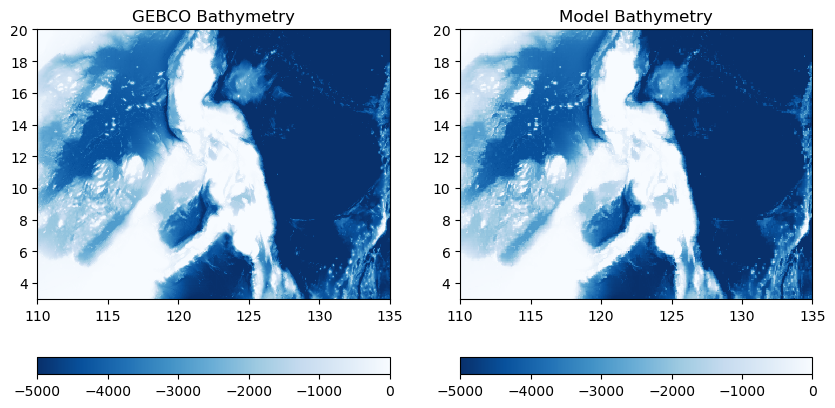

In [29]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
C = plt.pcolormesh(Gebco_Lon, Gebco_Lat, Gebco_bathy, vmin=-5000, vmax=0, cmap='Blues_r')
plt.colorbar(C, orientation = 'horizontal')
plt.title('GEBCO Bathymetry')

plt.subplot(1,2,2)
C = plt.pcolormesh(XC, YC, Model_bathy, vmin=-5000, vmax=0, cmap='Blues_r')
plt.colorbar(C, orientation = 'horizontal')
plt.title('Model Bathymetry')

plt.show()

### Checking for isolated regions
One potential problem that can be encountered in ocean models occurs with isolated regions

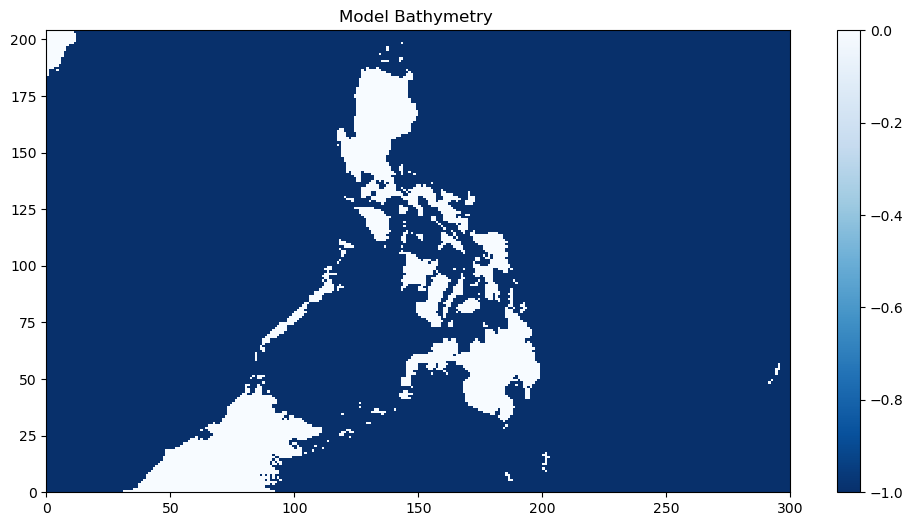

In [30]:
plt.figure(figsize=(12,6))

C = plt.pcolormesh(Model_bathy, vmin=-1, vmax=0, cmap='Blues_r')
plt.colorbar(C)
plt.title('Model Bathymetry ')

plt.show()

Given the vast amount of islands in the Philippines, there is a high potential of isolated regions existing. In addition, there is an area of extreme detail in the center of the Philippines islands.

Fortunately, Mike has written a tool to fill in these unconnected regions. You can clone his [eccoseas](https://github.com/mhwood/eccoseas) repository to access a tool related to this process. If you clone it in the current directory, you can use import it here:

In [31]:
import sys
from pathlib import Path

# Add parent directory to path
sys.path.append(str(Path("..").resolve()))

# Now you can import
from eccoseas.downscale import bathymetry as edb

With the tools imported, we can now use the `fill_unconnected_model_regions` to fill in these regions.

In [32]:
Model_bathy = edb.fill_unconnected_model_regions(Model_bathy, central_wet_row=100, central_wet_col=100)

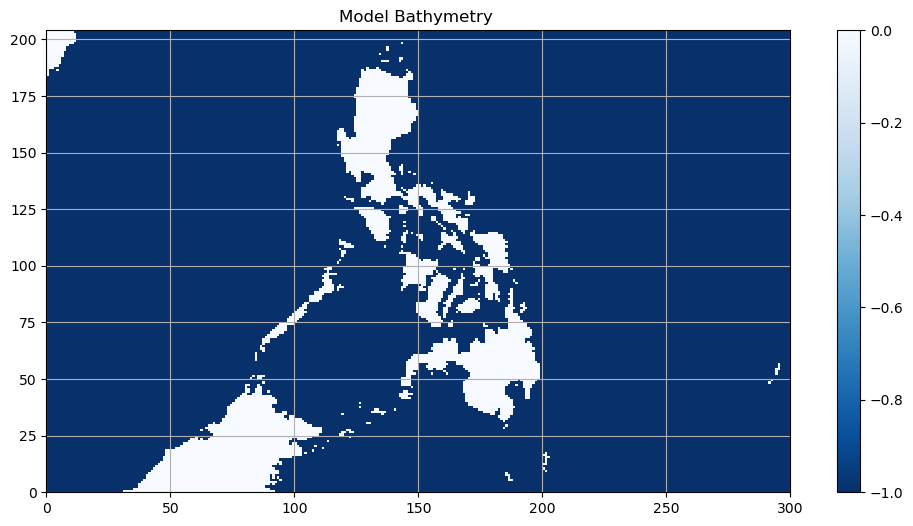

In [33]:
plt.figure(figsize=(12,6))

C = plt.pcolormesh(Model_bathy, vmin=-1, vmax=0, cmap='Blues_r')
plt.colorbar(C)
plt.grid()
plt.title('Model Bathymetry ')

plt.show()

### Checking for problem areas
Another potential problem that can be encountered in ocean models occurs in regions where there is shallow bathymetry in enclosed bays. I'll be filling a few large groups of islands in manually.

In [34]:
# fill in some areas around 
# latitude, longitude

Model_bathy_filled = np.copy(Model_bathy)
Model_bathy_filled[100:150, 135:165] = 0
Model_bathy_filled[50:125, 150:180] = 0
Model_bathy_filled[65:105, 175:190] = 0

Then, plot the filled bathymetry to ensure it looks as expected

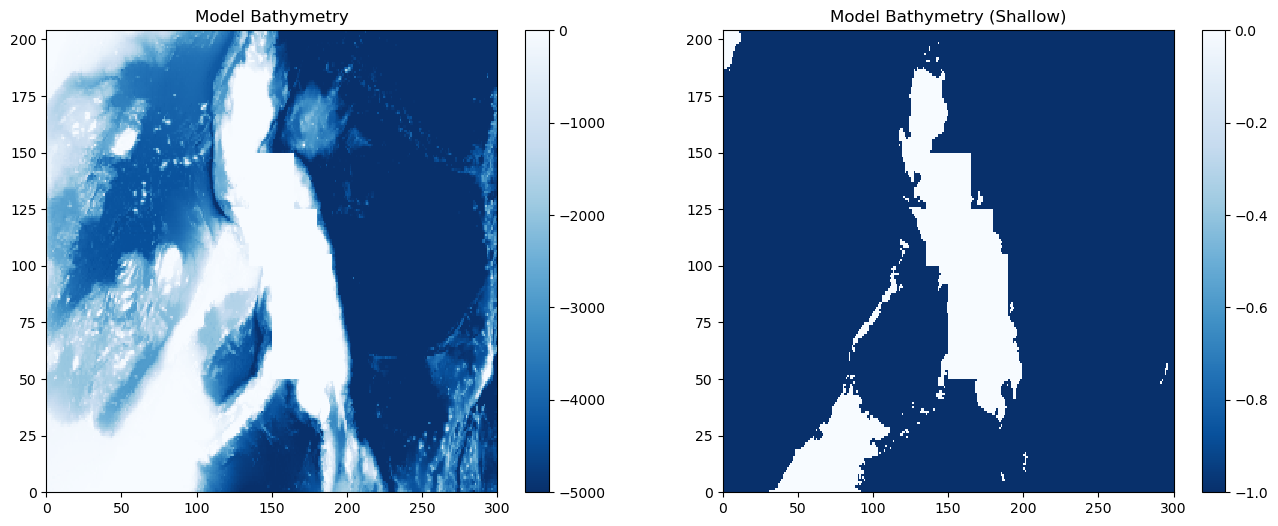

In [35]:
plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
C = plt.pcolormesh(Model_bathy_filled, vmin=-5000, vmax=0, cmap='Blues_r')
plt.colorbar(C)
plt.title('Model Bathymetry')

plt.subplot(1,2,2)
C = plt.pcolormesh(Model_bathy_filled, vmin=-1, vmax=0, cmap='Blues_r')
plt.colorbar(C)
plt.title('Model Bathymetry (Shallow)')

plt.show()

In [36]:
import os
output_file = 'Philippines_bathymetry.bin'
input_dir = '/Users/johnathonlu/Documents/SJSU/cs185c_spring2025/Project/input'
output_path = os.path.join(input_dir, output_file)

Model_bathy_filled.ravel('C').astype('>f4').tofile(output_path)

This will be implemented into the model by editing the `PARM05` dataset of the `data` file as follows:
```
 &PARM05
 bathyFile = 'CA_bathymetry.bin,
 &
```